In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import re
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("code-snippets.csv")
df

,language,code
0,c,#include <stdio.h>\n#include <stdlib.h>\n\n#de...
1,c,#include <stdlib.h>\n#include <string.h>\n#inc...
2,c,#include <stdio.h>\n#include <stdlib.h>\n\nflo...
3,c,write(1)\nwall(1)\n#include <stdlib.h>\n#inclu...
4,c,"while(ch = getchar(), ch >= 0)\n// from main()..."
...,...,...
15040,swift,UIDatePicker\nif theDatePicker == strDate {\n ...
15041,swift,...\n//var memoArea = UITextView(frame: CGRect...
15042,swift,let nextView = self.storyboard?.instantiateVie...
15043,swift,import UIKit\n import CoreLocation\n class Vi...


In [3]:
df.shape

(15045, 2)

In [4]:
df['language'].value_counts()

language
c             885
perl          885
sqlite        885
scala         885
ruby          885
r             885
python        885
php           885
objc          885
cpp           885
lua           885
javascript    885
java          885
html          885
haskell       885
css           885
swift         885
Name: count, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15045 entries, 0 to 15044
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   language  15045 non-null  object
 1   code      15045 non-null  object
dtypes: object(2)
memory usage: 235.2+ KB


In [6]:
df.isnull().sum()

language    0
code        0
dtype: int64

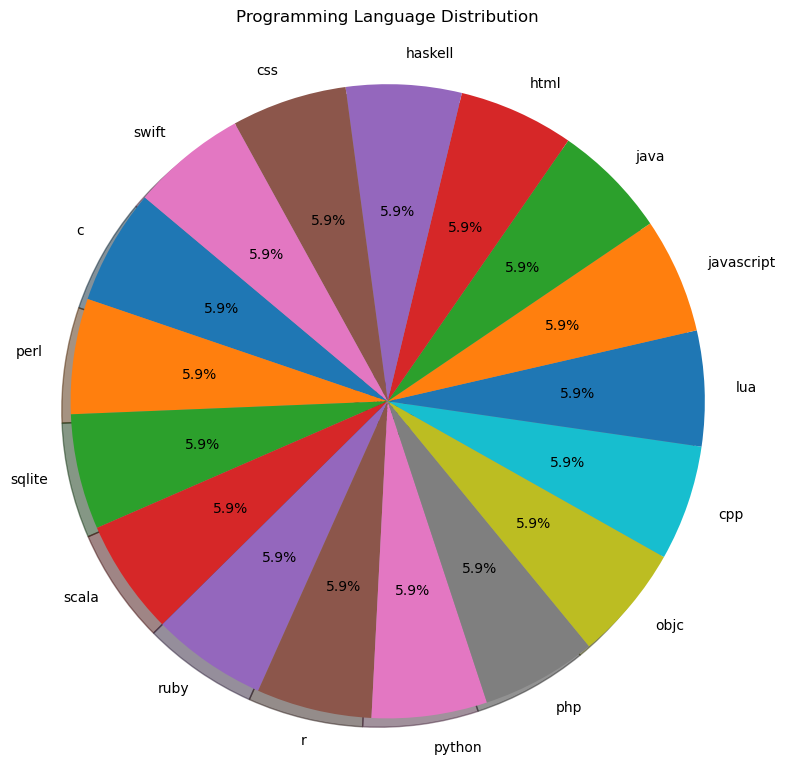

In [7]:
lang_counts = df['language'].value_counts()

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(lang_counts, labels=lang_counts.index, autopct='%1.1f%%', startangle=140, shadow=True)
plt.title("Programming Language Distribution")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

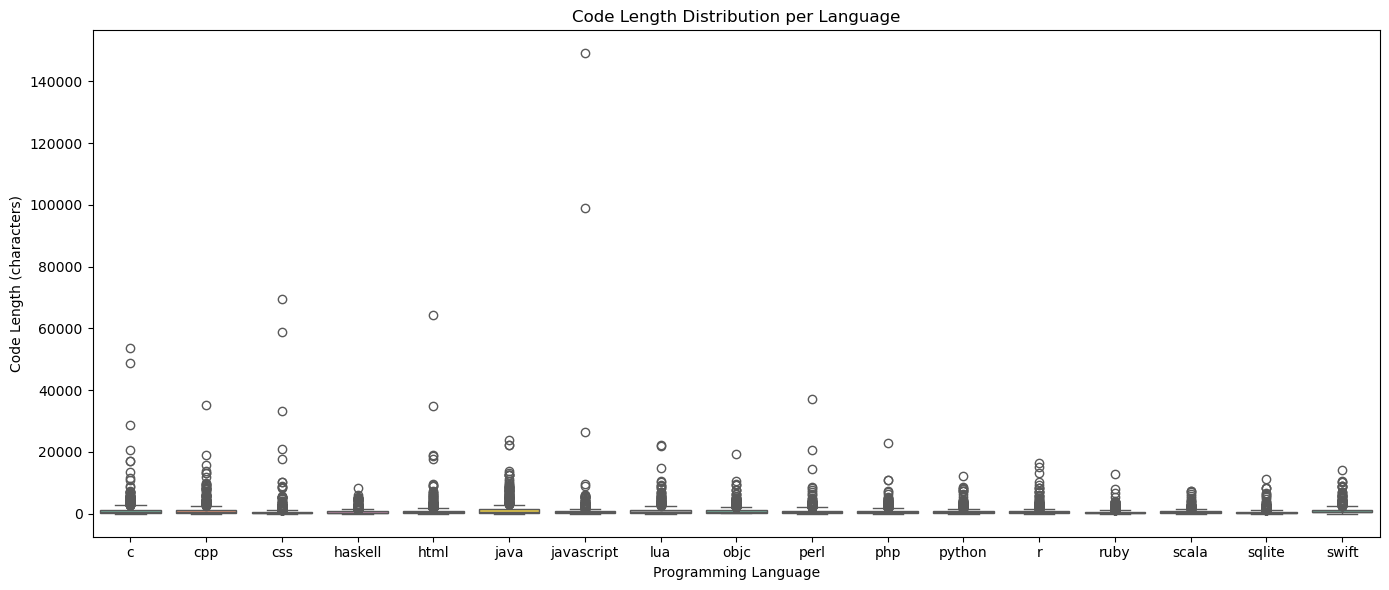

In [8]:
df['code_length'] = df['code'].apply(len)

# Filter top 10 most frequent languages
top_langs = df['language'].value_counts().index
df_top_langs = df[df['language'].isin(top_langs)]

# Create box plot
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_top_langs, x='language', y='code_length', palette='Set2')
plt.title("Code Length Distribution per Language")
plt.xlabel("Programming Language")
plt.ylabel("Code Length (characters)")
plt.tight_layout()
plt.show()

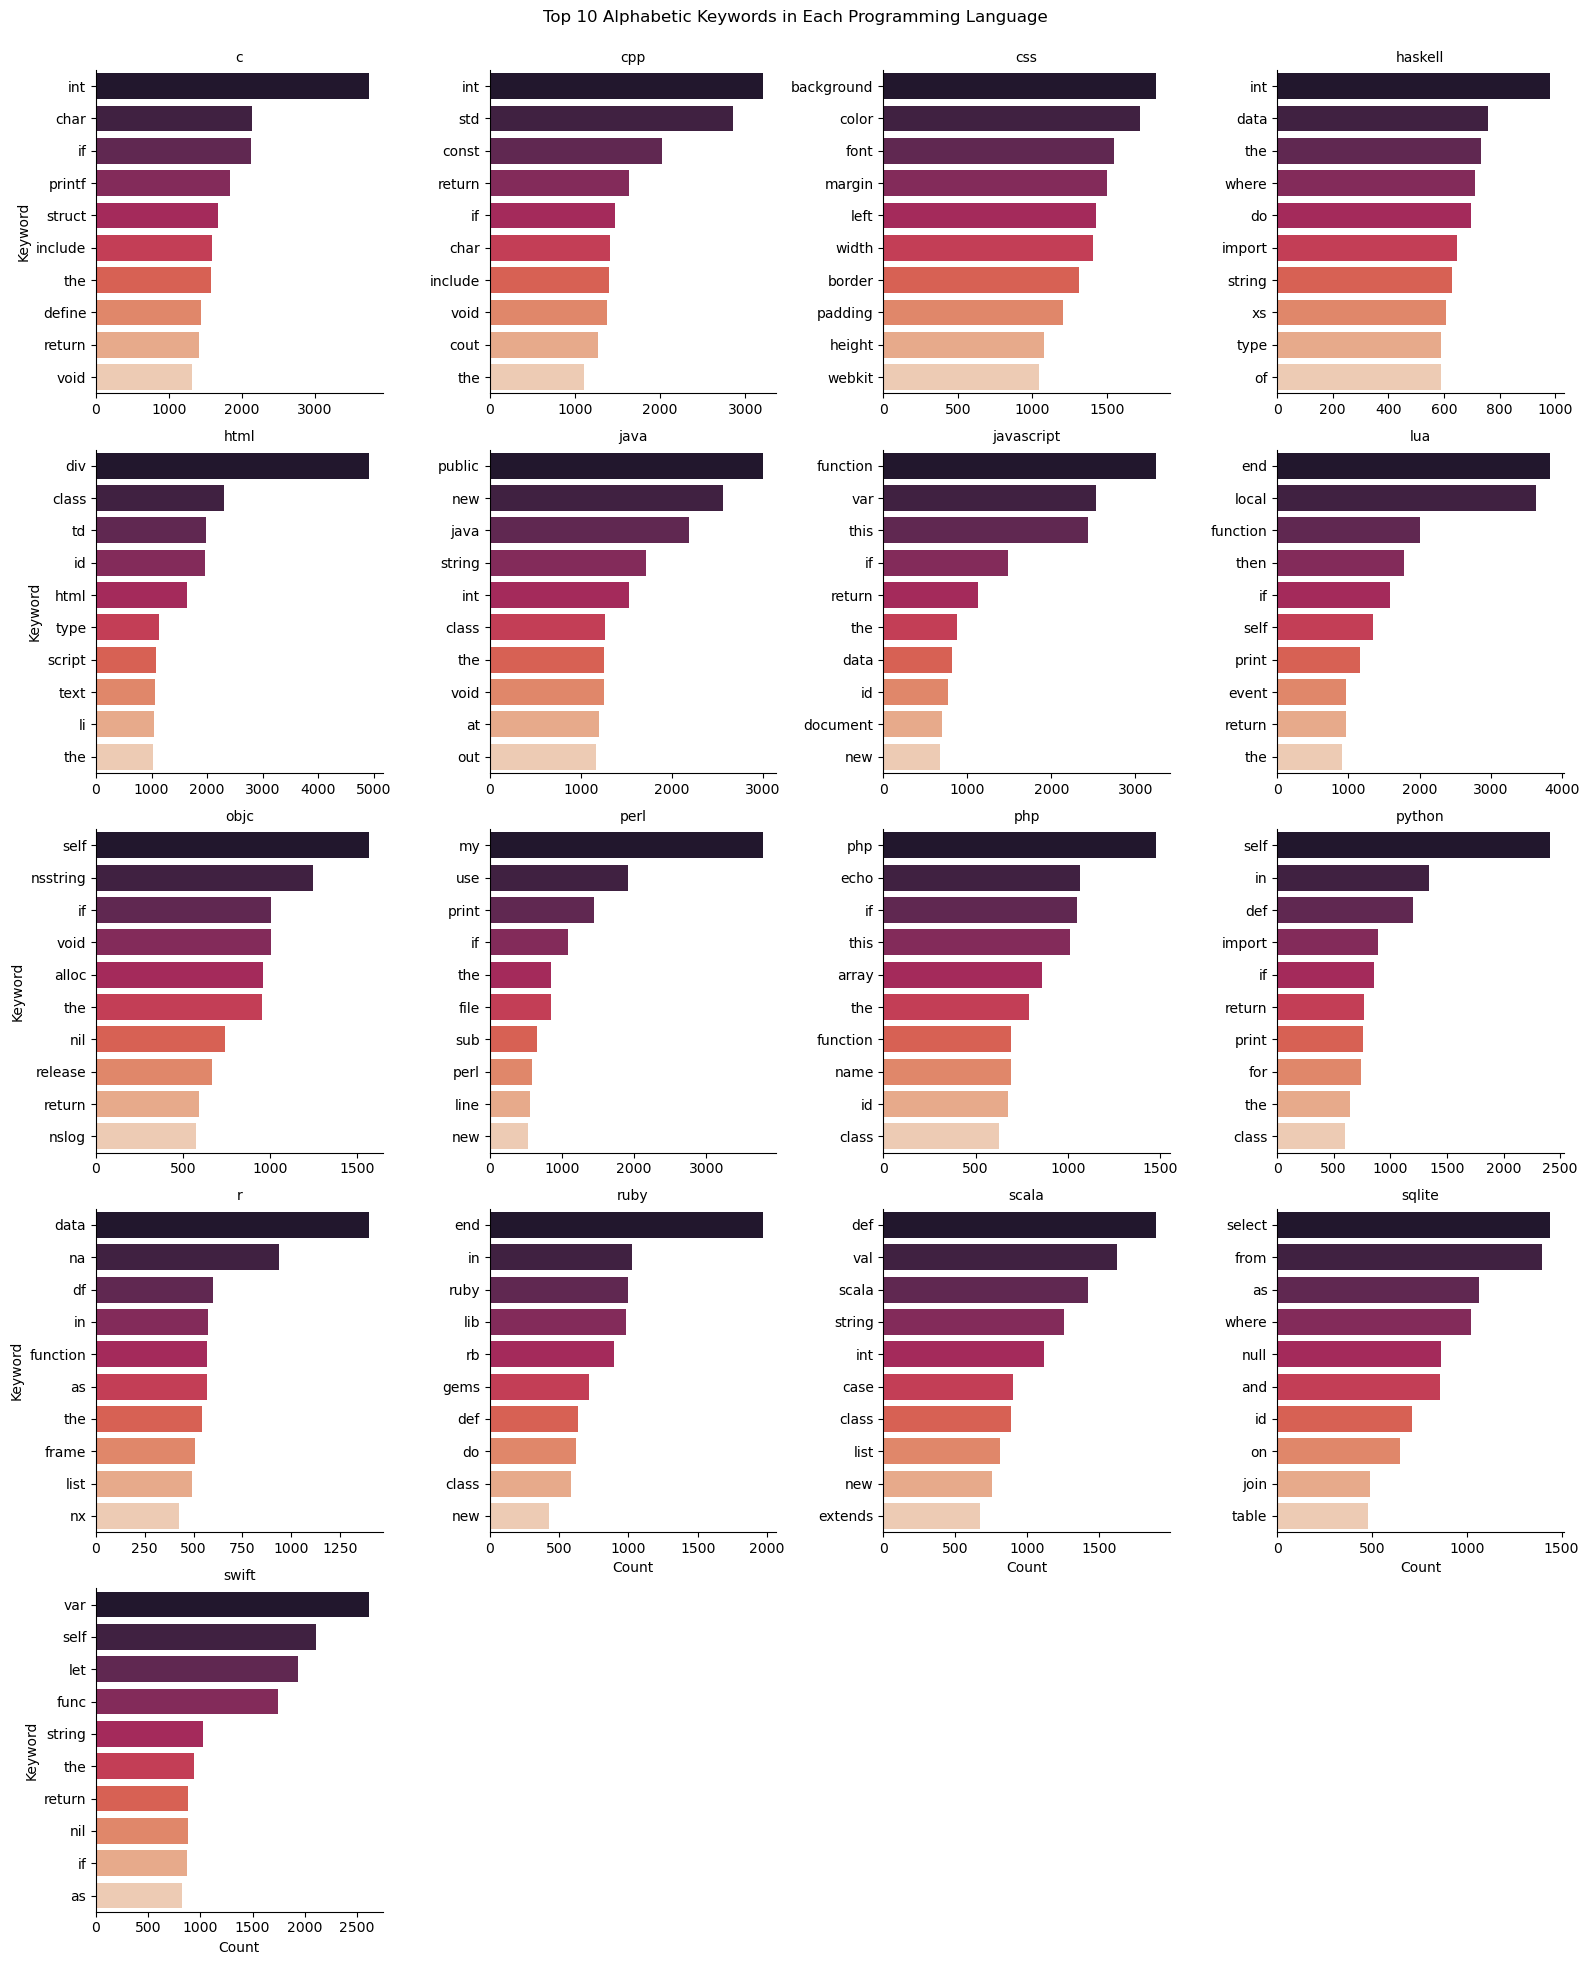

In [9]:
# Function to get top N alphabetic keywords per language
def get_top_keywords_per_language(df, top_n=10):
    lang_keywords = {}
    for lang in df['language'].unique():
        texts = df[df['language'] == lang]['code']
        words = " ".join(texts).lower()
        # Extract only alphabetic tokens (no digits/symbols)
        tokens = re.findall(r'\b[a-zA-Z_]{2,}\b', words)
        common = Counter(tokens).most_common(top_n)
        lang_keywords[lang] = common
    return lang_keywords

# Get top keywords
top_keywords = get_top_keywords_per_language(df, top_n=10)

# Prepare for plotting
keyword_data = []
for lang, keywords in top_keywords.items():
    for word, count in keywords:
        keyword_data.append({'language': lang, 'word': word, 'count': count})

keyword_df = pd.DataFrame(keyword_data)

# Plot using FacetGrid
g = sns.FacetGrid(keyword_df, col="language", col_wrap=4, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.barplot, x="count", y="word", palette="rocket")
g.set_titles("{col_name}")
g.set_axis_labels("Count", "Keyword")
plt.subplots_adjust(top=0.95)
g.fig.suptitle("Top 10 Alphabetic Keywords in Each Programming Language")
plt.show()

In [10]:
patterns = {
    "Escaped newline (\\n)": r"\\n",
    "Escaped carriage return (\\r)": r"\\r",
    "Escaped tab (\\t)": r"\\t",
    "Multiple spaces": r"[ ]{2,}",
    "Excessive newlines": r"\n{3,}",
    "Non-printable characters": r"[^\x20-\x7E\n]",
}

In [11]:
# Check presence of each pattern
print("Noise Pattern Presence:")
for label, pattern in patterns.items():
    found = False
    for code in df['code']:
        if re.search(pattern, code):
            found = True
            break
    if found:
        print(f"Found → {label}")
    else:
        print(f"Not Found → {label}")

Noise Pattern Presence:
Found → Escaped newline (\n)
Found → Escaped carriage return (\r)
Found → Escaped tab (\t)
Found → Multiple spaces
Found → Excessive newlines
Found → Non-printable characters


In [12]:
def clean_code(code):
    if not isinstance(code, str):
        return ""

    # Replace escaped newline, carriage return, and tab with space
    code = re.sub(r'[\s\r\n\t]+', "", code)

    # Remove non-printable characters (excluding newlines)
    code = re.sub(r"[^\x20-\x7E]", "", code)

    # Replace multiple spaces with a single space
    code = re.sub(r"\s{2,}", " ", code)

    # Remove excessive newlines (optional: keep 1 newline max)
    code = re.sub(r"\n{2,}", "\n", code)

    # Final cleanup: strip leading/trailing whitespace
    return code.strip()

In [13]:
df['clean_code'] = df['code'].apply(clean_code)
df

,language,code,code_length,clean_code
0,c,#include <stdio.h>\n#include <stdlib.h>\n\n#de...,449,#include<stdio.h>#include<stdlib.h>#defineITER...
1,c,#include <stdlib.h>\n#include <string.h>\n#inc...,829,#include<stdlib.h>#include<string.h>#include<s...
2,c,#include <stdio.h>\n#include <stdlib.h>\n\nflo...,401,#include<stdio.h>#include<stdlib.h>floatvalues...
3,c,write(1)\nwall(1)\n#include <stdlib.h>\n#inclu...,1270,write(1)wall(1)#include<stdlib.h>#include<stri...
4,c,"while(ch = getchar(), ch >= 0)\n// from main()...",161,"while(ch=getchar(),ch>=0)//frommain()://printS..."
...,...,...,...,...
15040,swift,UIDatePicker\nif theDatePicker == strDate {\n ...,1620,UIDatePickeriftheDatePicker==strDate{playTheSo...
15041,swift,...\n//var memoArea = UITextView(frame: CGRect...,2334,...//varmemoArea=UITextView(frame:CGRectMake(2...
15042,swift,let nextView = self.storyboard?.instantiateVie...,617,letnextView=self.storyboard?.instantiateViewCo...
15043,swift,import UIKit\n import CoreLocation\n class Vi...,517,importUIKitimportCoreLocationclassViewControll...


In [14]:
X = df['clean_code']
y = df['language']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', ngram_range=(1, 2), stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred) * 100

print("Logistic Regression Accuracy:", lr_acc)
print("Classification Report:\n", classification_report(y_test, lr_pred))

Logistic Regression Accuracy: 87.17181787969425
Classification Report:
               precision    recall  f1-score   support

           c       0.86      0.91      0.89       179
         cpp       0.96      0.84      0.89       182
         css       0.93      0.94      0.93       175
     haskell       0.88      0.82      0.85       183
        html       0.86      0.93      0.90       184
        java       0.89      0.94      0.91       176
  javascript       0.89      0.91      0.90       185
         lua       0.87      0.80      0.83       163
        objc       0.94      0.94      0.94       192
        perl       0.89      0.90      0.89       184
         php       0.87      0.84      0.85       197
      python       0.87      0.76      0.81       184
           r       0.89      0.90      0.89       172
        ruby       0.77      0.77      0.77       168
       scala       0.81      0.86      0.84       158
      sqlite       0.72      0.85      0.78       170
       sw

<Figure size 1000x800 with 0 Axes>

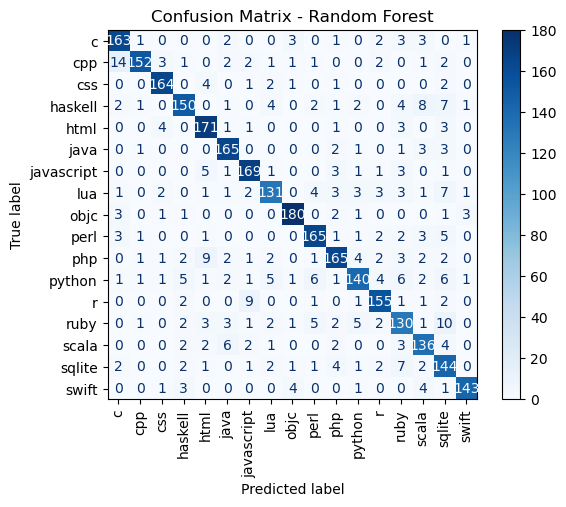

In [16]:
cm = confusion_matrix(y_test, lr_pred, labels=lr_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_pipeline.classes_)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=90, cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [17]:
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(3, 5))),
    ('clf', MultinomialNB())
])

nb_pipeline.fit(X_train, y_train)
nb_pred = nb_pipeline.predict(X_test)
nb_acc = accuracy_score(y_test, nb_pred) * 100

print("Multinomial Naive Bayes Accuracy:", nb_acc)
print("Classification Report:\n", classification_report(y_test, nb_pred))

Multinomial Naive Bayes Accuracy: 91.69159189099368
Classification Report:
               precision    recall  f1-score   support

           c       0.89      0.97      0.93       179
         cpp       0.96      0.82      0.88       182
         css       0.95      0.97      0.96       175
     haskell       0.99      0.84      0.91       183
        html       0.88      0.96      0.92       184
        java       0.74      0.99      0.84       176
  javascript       0.91      0.93      0.92       185
         lua       0.93      0.94      0.94       163
        objc       0.96      0.96      0.96       192
        perl       0.99      0.98      0.98       184
         php       0.96      0.89      0.92       197
      python       0.99      0.83      0.90       184
           r       0.96      0.92      0.94       172
        ruby       0.99      0.83      0.91       168
       scala       0.97      0.86      0.91       158
      sqlite       0.93      0.92      0.93       170
     

<Figure size 1000x800 with 0 Axes>

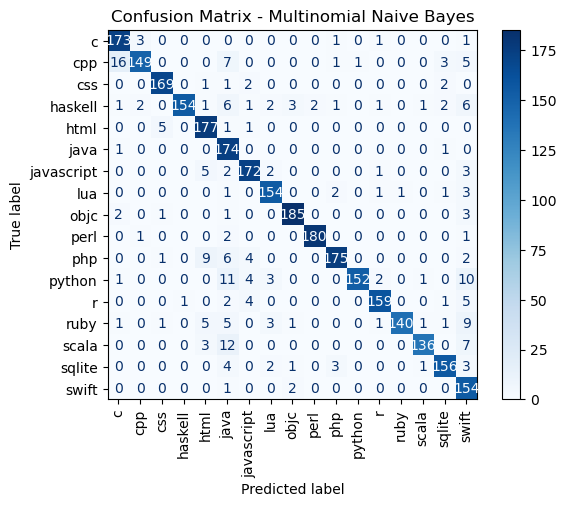

In [18]:
cm = confusion_matrix(y_test, nb_pred, labels=nb_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_pipeline.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=90, cmap='Blues')
plt.title("Confusion Matrix - Multinomial Naive Bayes")
plt.show()

In [21]:
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 6), max_features=10000)),
    ('clf', RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42))
])


rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred) * 100

print("Accuracy:", rf_acc)
print("\nClassification Report:\n", classification_report(y_test, rf_pred))

Accuracy: 94.41674975074775

Classification Report:
               precision    recall  f1-score   support

           c       0.93      0.97      0.95       179
         cpp       0.96      0.88      0.92       182
         css       0.95      0.96      0.95       175
     haskell       0.84      0.97      0.90       183
        html       0.94      0.98      0.96       184
        java       0.98      0.97      0.97       176
  javascript       0.95      0.95      0.95       185
         lua       0.96      0.92      0.94       163
        objc       0.98      0.95      0.97       192
        perl       0.99      0.92      0.96       184
         php       0.97      0.91      0.94       197
      python       0.89      0.93      0.91       184
           r       0.99      0.92      0.95       172
        ruby       0.89      0.92      0.91       168
       scala       0.99      0.96      0.97       158
      sqlite       0.90      0.98      0.94       170
       swift       0.99     

In [23]:
grid_search_rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 6), max_features=10000)),
    ('clf', RandomForestClassifier(random_state=42))
])

# Focused param grid for fast tuning
param_grid = {
    'clf__n_estimators': [200, 300],
    'clf__max_depth': [30, None],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__class_weight': ['balanced_subsample']
}


grid_search_rf = GridSearchCV(
    grid_search_rf_pipeline,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

best_model = grid_search_rf.best_estimator_
rf_pred = best_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred) * 100

print("Accuracy:",rf_acc)
print("Best Parameters:", grid_search_rf.best_params_)
print("Classification Report:\n", classification_report(y_test, rf_pred))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Accuracy: 94.35028248587571
Best Parameters: {'clf__class_weight': 'balanced_subsample', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Classification Report:
               precision    recall  f1-score   support

           c       0.92      0.97      0.95       179
         cpp       0.96      0.88      0.92       182
         css       0.95      0.96      0.95       175
     haskell       0.86      0.96      0.91       183
        html       0.94      0.98      0.96       184
        java       0.98      0.97      0.97       176
  javascript       0.94      0.96      0.95       185
         lua       0.96      0.93      0.94       163
        objc       0.97      0.96      0.97       192
        perl       0.99      0.93      0.96       184
         php       0.97      0.92      0.94       197
      python       0.90      0.91      0.91       184
           r    

<Figure size 1000x800 with 0 Axes>

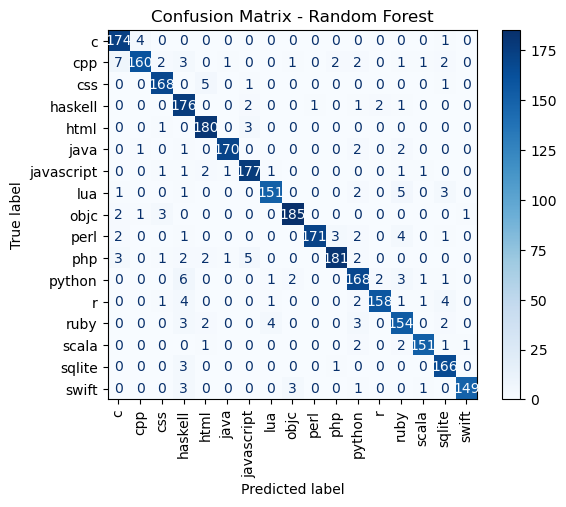

In [24]:
lr_acc = accuracy_score(y_test, lr_pred) * 100
rf_acc = accuracy_score(y_test, rf_pred) * 100
nb_acc = accuracy_score(y_test, nb_pred) * 100
cm = confusion_matrix(y_test, rf_pred, labels=rf_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_pipeline.classes_)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=90, cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

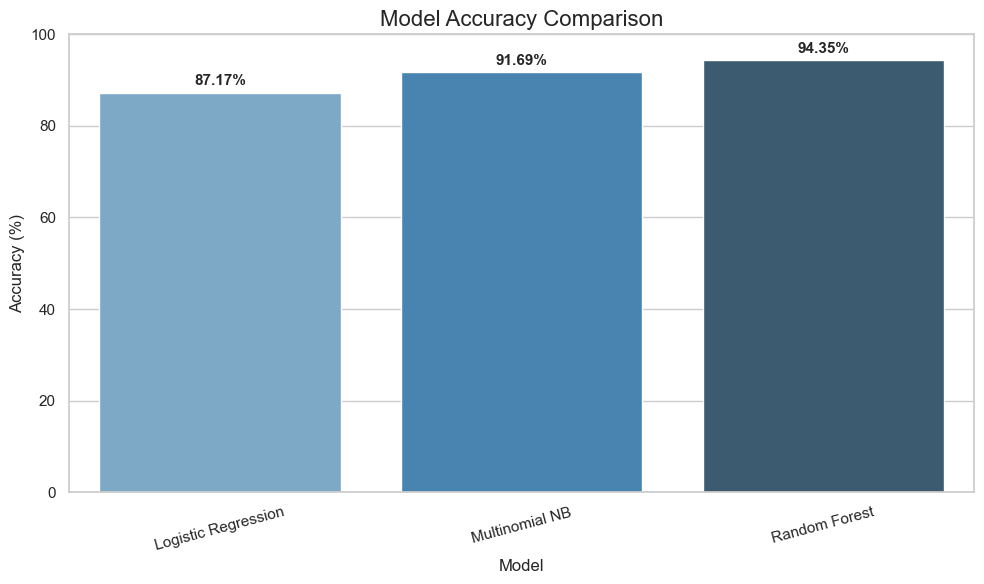

In [25]:
models = ['Logistic Regression', 'Multinomial NB', 'Random Forest']
accuracies = [lr_acc, nb_acc, rf_acc]

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
barplot = sns.barplot(x=models, y=accuracies, palette='Blues_d')

for i, acc in enumerate(accuracies):
    barplot.text(i, acc + 1, f"{acc:.2f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Model Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.xlabel('Model')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [26]:
joblib.dump(grid_search_rf, 'lang_detect_model.joblib')

['lang_detect_model.joblib']